In [4]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline

In [5]:
# df -> DataFrame
df = pd.read_csv('data.csv')
# Number of rows in df
len(df)

11914

In [6]:
# First five rows in df
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [7]:
# Normalize all column names 
df.columns = df.columns.str.lower().str.replace(' ', '-')
# Select cols with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns: 
    df[col] = df[col].str.lower().str.replace(' ', '-') 

In [8]:
df.head()

,make,model,year,engine-fuel-type,engine-hp,engine-cylinders,transmission-type,driven_wheels,number-of-doors,market-category,vehicle-size,vehicle-style,highway-mpg,city-mpg,popularity,msrp
0,bmw,1-series-m,2011,premium-unleaded-(required),335.0,6.0,manual,rear-wheel-drive,2.0,"factory-tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1-series,2011,premium-unleaded-(required),300.0,6.0,manual,rear-wheel-drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1-series,2011,premium-unleaded-(required),300.0,6.0,manual,rear-wheel-drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1-series,2011,premium-unleaded-(required),230.0,6.0,manual,rear-wheel-drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1-series,2011,premium-unleaded-(required),230.0,6.0,manual,rear-wheel-drive,2.0,luxury,compact,convertible,28,18,3916,34500


<Axes: xlabel='msrp', ylabel='Count'>

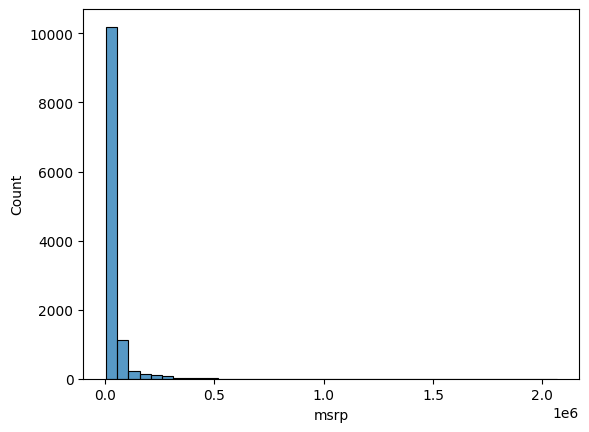

In [9]:
# plot a histogram of the target variable (or y) which is msrp
sns.histplot(df.msrp, bins=40)

#### Graph has a long "tail" which means we have more cars with low prices than we do for higher prices. The cutoff seems to be $100,000

<Axes: xlabel='msrp', ylabel='Count'>

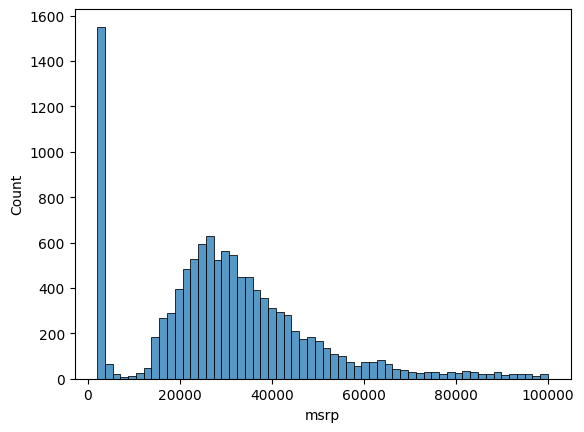

In [10]:
sns.histplot(df.msrp[df.msrp < 100000])

#### Now we see a much more even distribution, but the number of cars that cost $1k are still in the largest quantity by a lot, so we apply a log transformation to remove the "long tail" effect and make sure we don't confuse the model

<Axes: xlabel='msrp', ylabel='Count'>

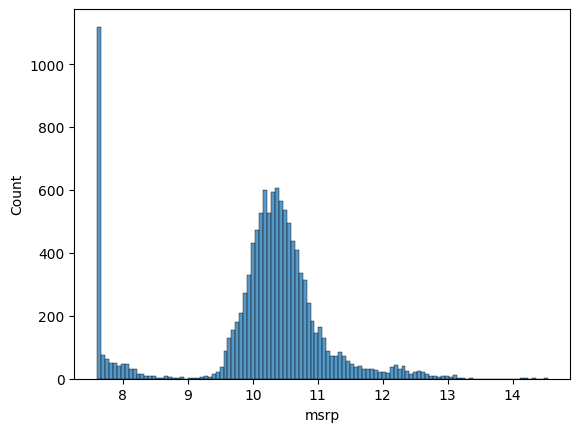

In [11]:
# new_price = log(old_price + 1) -> +1 because log(0) ~ -inf
log_price = np.log1p(df.msrp)
sns.histplot(log_price)

#### It is important that the distribution resembles a normal distribution for linear regression to perform better

In [12]:
# Check for missing values
df.isnull().sum()

make                    0
model                   0
year                    0
engine-fuel-type        3
engine-hp              69
engine-cylinders       30
transmission-type       0
driven_wheels           0
number-of-doors         6
market-category      3742
vehicle-size            0
vehicle-style           0
highway-mpg             0
city-mpg                0
popularity              0
msrp                    0
dtype: int64

In [14]:
# Validation framework needs to be set up ASAP so that the model can generalize. For that purpose
# DF will be split as follows -> + 60% Training + 20% Validation + 20% Test

# Get number of rows in DF
n = len(df)

# Calculate number of rows to be split according to above
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

# Fix a random seed to make sure results are reproducible (at least on the same machine)
np.random.seed(2)
# Create a shuffled NP array with all the indices 
idx = np.arange(n)
np.random.shuffle(idx)

# Use the array with indices to get a shuffled DF
df_shuffled = df.iloc[idx]
# Split shuffled DF into train, validation and test.
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [15]:
# Log transformation to remove the long tail effect again
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# NOTE: We don't want to use the target variable accidentaly, so we remove it from the DFs
del df_train['msrp']
del df_test['msrp']
del df_val['msrp']

## Now we start training

#### Since the goal is to predict a number (msrp), which is a regression problem, we train this model using regression
##### Specifically, Linear Regression since it is the simplest model

Basic linear regression: 
g(xi) = w0 + sum(xij * wj) 

In [16]:
# Linear regression implemented using numPy 
def train_linear_regression(X, y): 
    # Dummy column
    ones = np.ones(X.shape[0])
    # Add dummy column as the first col of X
    X = np.column_stack([ones, X])

    # Normal equation (The formula for weights calculation in linear regression)
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    # Weights vector
    w = XTX_inv.dot(X.T).dot(y)
    # Split weights vector into bias (w0), rest of weights
    return w[0], w[1:]

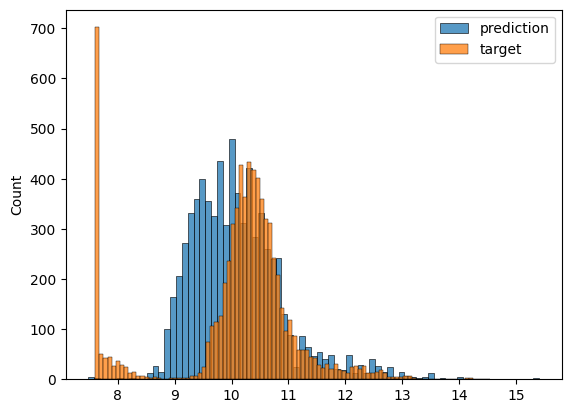

In [25]:
# Baseline (naive) solution
# We start with only a few numerical features to form X.
base = ['engine-hp', 'engine-cylinders', 'highway-mpg', 'city-mpg', 'popularity']
df_num = df_train[base]
# Before starting, we must fill all the missing rows with 0, so that we can make predictions on rows that contain 
# values, without affecting the model's accuracy
df_num = df_num.fillna(0)

# Convert DF to NP array
X_train = df_num.values
# TRAIN!!
w_0, w = train_linear_regression(X_train, y_train)
# Predictions: 
y_pred = w_0 + X_train.dot(w)

# Comparing predictions with actual distribution:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()

#### Conclusion to baseline solution: 
Since the prediction looks different from actual values, the baseline model is not strong enough to capture the distribution of the target variable (msrp). 